# CNN Example: cifar10
### Goal: 辨識十類彩色物件圖片
- 圖片: 32*32

## Step1: Load Data

In [2]:
from tensorflow.keras.datasets.cifar10 import load_data
(x_train, y_train),(x_test, y_test) = load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [3]:
# 查看資料訊息
print(x_train.shape) 
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
# (50000, 32, 32, 3) -> 50000筆訓練題目，32*32圖像，色彩通道:3 (R、G、B)
# (50000, 1) -> (答案是二維矩陣)
# (10000, 32, 32, 3) -> 10000筆測試題目，32*32圖像，色彩通道:3 (R、G、B)
# (10000, 1) -> (答案是二維矩陣)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
print(y_train)
# y_train及y_test -> 二維矩陣
# 為了未來可能會需要的擴充性 -> 一張圖片出現兩種以上的東西 (類別)
# 如果是這樣 -> 多個二分類 (因為每個答案不是互斥的 ，即可能同時出現海豚、青蛙) => 激活函式選擇(Sigmoid)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [0]:
# 創建答案數字對應的類別List
names = ["airplane",
         "automobile",
         "bird",
         "cat",
         "deer",
         "dog",
         "frog",
         "horse",
         "ship",
         "truck"]

ans: truck
(32, 32, 3)


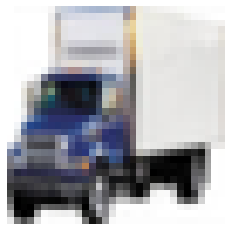

In [6]:
# 隨機印出答案與一張圖 
import random
import matplotlib.pyplot as plt
%matplotlib inline

idx = random.randint(0, 49999)
# y_train -> 二維矩陣
# y_train.shape -> (50000, 1)
# y_train[idx] -> [隨機數字]
print("ans:", names[y_train[idx][0]])

# x_train[idx] -> 三維矩陣
print(x_train[idx].shape)
plt.axis("off")
plt.imshow(x_train[idx])

## Step2: Data preprocessing - Normalize 
- #### Goal: Normalize - 把訓練集和測試集題目原本0 ~ 255的值調整到0 ~ 1之間

> ### 為何不用Reshape?                
> 一開始進入的是卷積層，而Conv2D可接受二維資料，因此不需要攤開               
> 在進入MLP層時再用Flatten()做reshape (Step3-1第4點)


> ### 為何不用對答案(y_train、y_test)做One-Hot Encoding? 
> 理論上需要，但之後在模型compile步驟時(Step3-2)，loss會選擇SparseCategoricalCrossentropy()，而它就會幫我們在需要時做One-Hot Encoding

In [0]:
x_train_norm = x_train / 255
x_test_norm = x_test / 255

## Step3-1: 建立神經網路模型
1. #### 建立模型支架: Sequential()    
2. #### 堆上卷積層: Conv2D()
model.add(Conv2D(filters, kernel_size, strides, padding="",activation="",input_shape=( , , )))
   - kernal_size: 選3 * 3就好，因為選5 * 5就等於兩層3 * 3；調整filters功能一樣
   - strides: 一次移動幾格，效果類似卷積 + 池化。選size%stride=0 的filter (ex.stride=2: 4 * 4的filter)
   - padding = "same": 有padding；padding = "valid": 無padding
   - input_shape: 第一層需設定

3. #### 做池化: MaxPooling2D()
MaxPooling2D(pool_size=( , ))
   - MaxPooling2D(pool_size=(2,2))，做2 * 2的max pooling
   - 其他池化方法: average pooling

#### ( 重複上述2.和3. )
4. #### 做reshape (平坦層): Flatten()
5. #### 堆上Layers: Dense (全連接層，Fully Connected Layer)

> ### 為何filter數的選擇(即Conv2D的第一個參數)為64、128、256?
> 參考著名卷積網路VGG-16: filter數是上一層的2倍；(VGG-16有16層，此例簡化成3層)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
# 建立模型支架
model = Sequential()
# 堆上卷積層，filter=64
model.add(Conv2D(64,
                (3,3),
                padding="same",
                activation="relu",
                input_shape=(32, 32, 3)))
# 做池化
model.add(MaxPooling2D())
# 堆上卷積層，filter=128
model.add(Conv2D(128,
                (3,3),
                padding="same",
                activation="relu"))
# 做池化
model.add(MaxPooling2D())
# 堆上卷積層，filter=256
model.add(Conv2D(256,
                (3,3),
                padding="same",
                activation="relu"))
# 做池化
model.add(MaxPooling2D())
# 做reshape
model.add(Flatten())
# 堆上Layers
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

### Param :
![圖: CNN_Param](https://i.imgur.com/ztEznyv.jpg)
- 一個filter -> 一個激活函式 (activation) -> 配一個bias   

## Step3-2: 確定模型的訓練方式
- 確定模型的訓練方式的方式: compile()
> ### 為何選擇SparseCategoricalCrossentropy()代替One-Hot Encoding?
> One-Hot encoding致命缺點: 欄位爆炸，記憶體爆炸；而Sparse會自動在你需要時，才做One-Hot encoding

In [0]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

## Step3-3: 訓練模型

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
stop_callback = EarlyStopping(patience=3, restore_best_weights=True)
# save_callback = ModelCheckpoint("cifar10.h5", save_best_only=True)
model.fit(x_train_norm, 
          y_train,
          batch_size=200,
          epochs=100,
          validation_split=0.1,
          callbacks=[stop_callback],
          verbose=1)

Epoch 1/100
225/225 [==============================] - 3s 13ms/step - loss: 1.6874 - accuracy: 0.3766 - val_loss: 1.2705 - val_accuracy: 0.5504
Epoch 2/100
225/225 [==============================] - 3s 12ms/step - loss: 1.2309 - accuracy: 0.5624 - val_loss: 1.0522 - val_accuracy: 0.6290
Epoch 3/100
225/225 [==============================] - 3s 12ms/step - loss: 1.0342 - accuracy: 0.6342 - val_loss: 0.9319 - val_accuracy: 0.6792
Epoch 4/100
225/225 [==============================] - 3s 12ms/step - loss: 0.9063 - accuracy: 0.6830 - val_loss: 0.8024 - val_accuracy: 0.7200
Epoch 5/100
225/225 [==============================] - 3s 12ms/step - loss: 0.8052 - accuracy: 0.7190 - val_loss: 0.7542 - val_accuracy: 0.7454
Epoch 6/100
225/225 [==============================] - 3s 12ms/step - loss: 0.7227 - accuracy: 0.7463 - val_loss: 0.7290 - val_accuracy: 0.7520
Epoch 7/100
225/225 [==============================] - 3s 12ms/step - loss: 0.6561 - accuracy: 0.7691 - val_loss: 0.6987 - val_accuracy:

## Step4-1: Predict & Evaluate
#### 對測試集的10000筆資料進行預測；查看模型的正確率

In [11]:
model.evaluate(x_test_norm, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.7227 - accuracy: 0.7606


[0.7226804494857788, 0.7605999708175659]

In [12]:
pre = model.predict_classes(x_test_norm)
print(pre.shape)
pre

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
(10000,)


array([3, 8, 8, ..., 5, 4, 7])

## Step4-2: 印出所有預測錯誤的圖及其他資訊

In [13]:
# 觀察正確答案的型態
print(y_test.shape)
print(y_test)

# 將正確答案攤開成一維，才能與pre (預測答案) 做比較
y_test_1d = y_test.reshape(10000)
print(y_test_1d.shape)
print(y_test_1d)

(10000, 1)
[[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]
(10000,)
[3 8 8 ... 5 1 7]


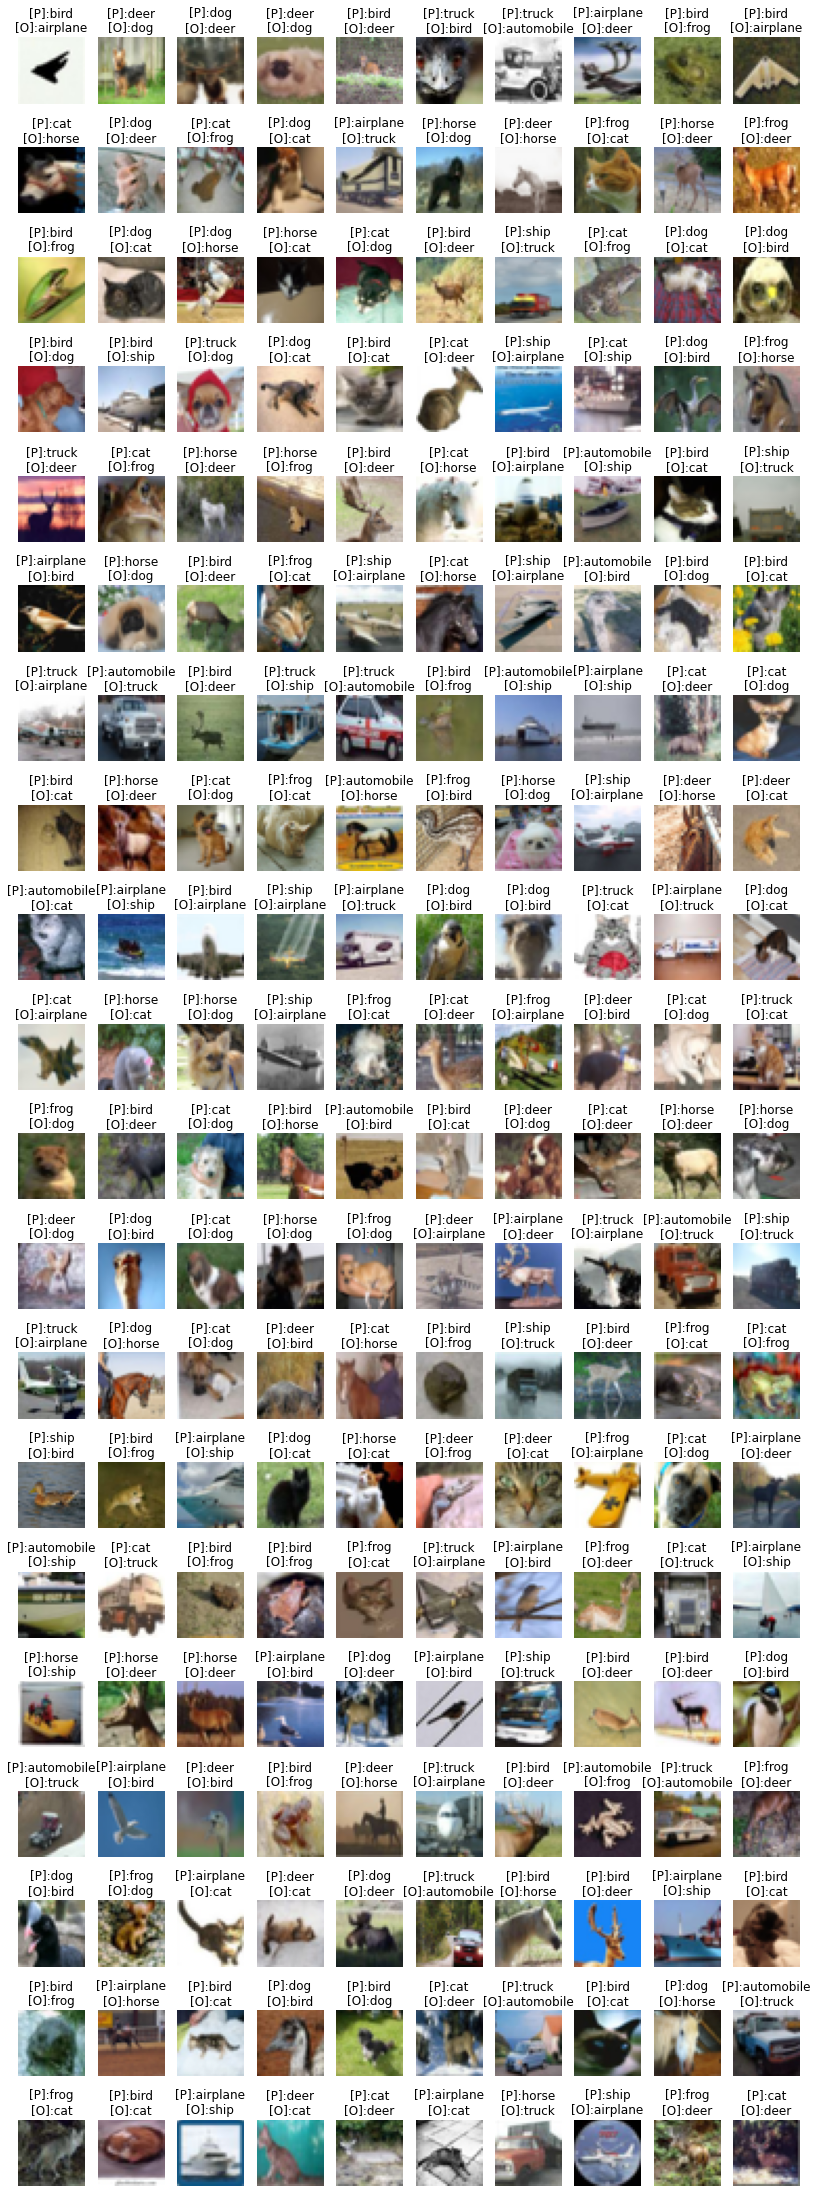

In [14]:
import numpy as np
idx = np.nonzero(pre != y_test_1d)[0][:200]
# np.nonzero(pre != y_test): 為一tuple，因此我們拿出第一項 =>[0]
# [:200]: 太多錯, 我只取前兩百個

false_pre_img = x_test[idx]
false_pre_label = y_test_1d[idx]
false_pre_predict = pre[idx]

plt.figure(figsize=(14, 42))
width = 10
height = len(idx) // width + 1

for i, img in enumerate(false_pre_img):
    plt.subplot(height, width, i+1)
    t = "[P]:{}\n[O]:{}".format(names[false_pre_predict[i]],
                                names[false_pre_label[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)
    
# enumerate: 幫每張圖列出索引 (0, 圖)、(1, 圖)......

## 利用此模型，製作數字圖片預測器

檔名:cat.jpg
正確答案應該是: cat


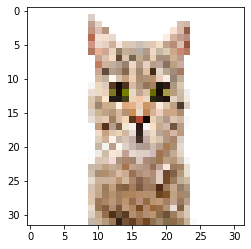

In [15]:
from tensorflow.keras.preprocessing.image import load_img
f = input("檔名:")
img_raw = load_img(f, target_size=(32, 32))
img = np.array(img_raw).reshape(1, 32, 32, 3) / 255
answer = model.predict_classes(img)[0]
print("正確答案應該是:", names[answer])
plt.imshow(img_raw)